# Библиотеки и настройка cuda

In [7]:
import os
import pandas as pd
import zipfile

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2080 SUPER'

# Модуль А. Анализ и предобработка данных

## Исходные данные для идентификации

* В первую очередь надо разархивировать исходные данные.

Данные будут извлекаться в папку "data"

In [7]:
# путь к архиву
arch = 'archive.zip'

with zipfile.ZipFile(arch, 'r') as zip_file:
    zip_file.extractall('data') # данные извлекаются и добавляются в папку data

Исходные данные:

* lfw-deepfunneled - в этой папке находятся папки с именами людей, а внутри их - фотографии этих людей.

* В файлах "people.csv" и "lfw_allnames.csv" указаны имена людей и количество фото в папках с ними (??????????????)

In [14]:
# читаем файлы csv и сохраняем их в датафрейм
df1 = pd.read_csv('data\people.csv', sep = ',')
df2 = pd.read_csv('data\lfw_allnames.csv', sep = ',')

In [13]:
df1.shape # размер df1

(5758, 2)

In [14]:
df2.shape # размер df2

(5749, 2)

Количество строк в df2 совпадает с количеством папок в папке lfw-deepfunneled -> можно сделать вывод, что файл lfw_allnames.csv содержит в себе информацию про исходный датасет. 

(остальные csv это что-то другое)

## Исходные данные для распознавания

* Разархивируем архив

Данные будут извлекаться в папку "data2"

In [15]:
# путь к архиву
arch2 = 'archive2.zip'

with zipfile.ZipFile(arch2, 'r') as zip_file2:
    zip_file2.extractall('data2') # извлечённые данные будут в папке data2

Данные для распознавания представлены в таком виде: в папке data2\Custom_Data есть папки images, с фотографиями, и labels с разметкой.

(внутри папок images и labels есть папка train и все фотографии лежат там)

У этого набора данных надо проверить разметку и исправить её в случае необходимости, но сначала можно посмотреть, какие классы есть в разметке и сколько там объектов.

In [10]:
from collections import defaultdict, OrderedDict # для словаря, в котором будет считаться
                                                 #кол-во объектов по классам

In [20]:
# путь к папке с разметкой
fol_path = r'data2\Custom_Data\labels\train'

class_vals = defaultdict(int)

for filename in os.listdir(fol_path):
    file_path = os.path.join(fol_path, filename)

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                first_space = line.find(' ')
                first_part = line[:first_space] if first_space != -1 else line

                if first_part.isdigit():
                    class_vals[int(first_part)] += 1

s_class_vals = OrderedDict(sorted(class_vals.items()))
print(s_class_vals)

OrderedDict([(0, 1424)])


Всего один класс - лицо. При изначальной разметке было размечено 1424 объектов.

Теперь сделаем проверку\переразметку в Yolo Annotation Tool 

Перед тем как начать разметку нужно сделать файл в формате .txt с классами. Так как класс один, в файле будет только одна строчка с номером класса.

Содержание файла:

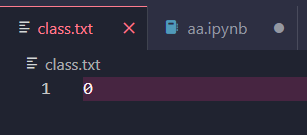

Есть объекты, разметку у которых лучше удалить. Пример на фотографиии ниже, в красном прямоугольнике: из-за того что лицо практически полностью закрыто и его, по сути, не видно, подобные объекты лучше удалять. Некорректные данные могут плохо сказаться на качестве модели

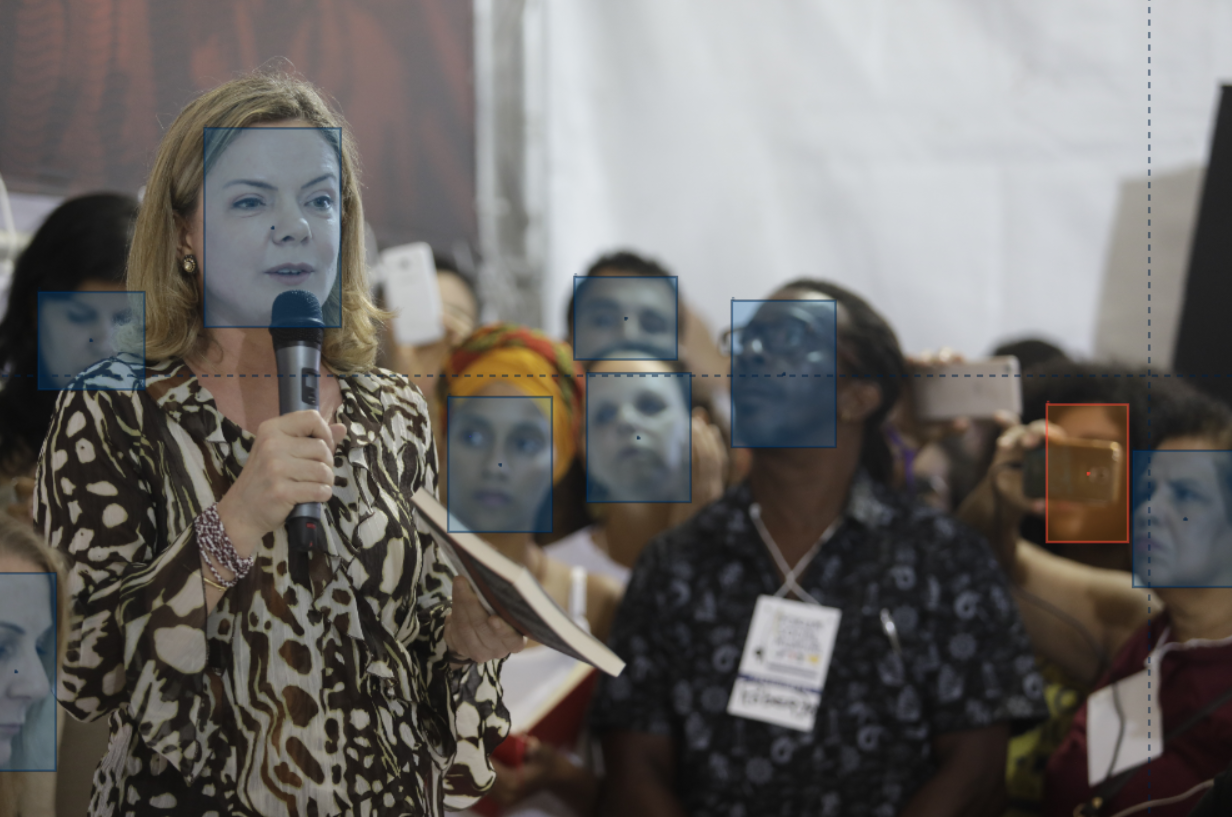

Так же я решила удалять объекты, который очень размытые и находятся далеко на заднем плане фотографии. Пример на фотографии ниже в красном прямоугольнике:

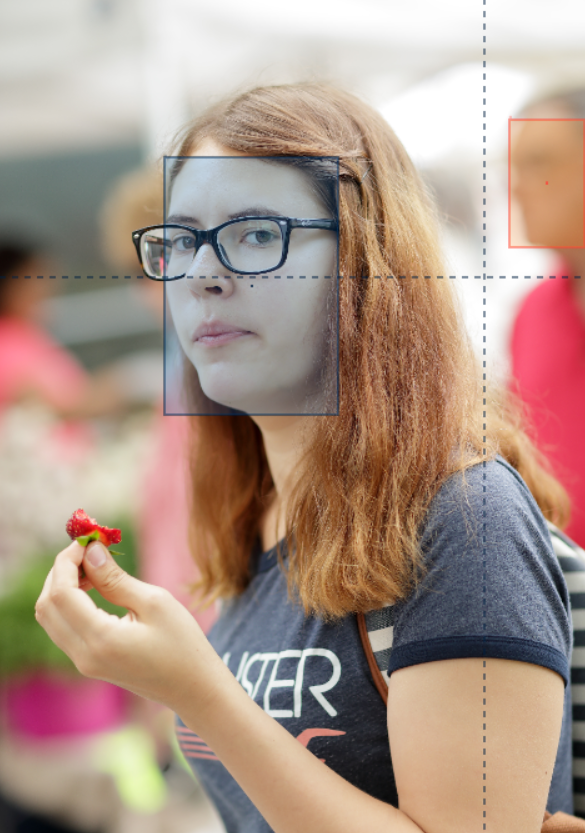

### Разархивация переразмеченных данных

Так как новая переразметка скачивается архивом, её надо извлечь. Извлечённые данные будут в папке "data_raz"

In [8]:
# путь к архиву
arch3 = 'bboxes_yolo.zip'

with zipfile.ZipFile(arch3, 'r') as zip_file3:
    zip_file3.extractall('data_raz') # данные извлекаются в data_raz

* В папке "data_raz" хранятся только .txt файлы с новой разметкой

________________________________________________________________________________________________________________________

Теперь нужно сделать словарь с переразмеченными данными, как я делала с исходными

In [12]:
# путь к папке с переразметкой
fol_path_new = 'data_raz'

class_vals_new = defaultdict(int)

for filename in os.listdir(fol_path_new):
    file_path = os.path.join(fol_path_new, filename)

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                first_space = line.find(' ')
                first_part = line[:first_space] if first_space != -1 else line

                if first_part.isdigit():
                    class_vals_new[int(first_part)] += 1

new_s_class_vals = OrderedDict(sorted(class_vals_new.items()))
print(new_s_class_vals)

OrderedDict([(0, 1331)])


___________________________________________________________________________________________________________________________

#### Сравнение кол-ва данных до и после переразметки

Исходная разметка:
>OrderedDict([(0, 1424)])

Новая разметка:

>OrderedDict([(0, 1331)])

* Новые лица обнаружены не были
* Удалены некорреткно размеченные объекты (меньше 40-50% от лица на кадре, очень размытые лица)

В итоге количество размеченных объектов уменьшилось на 93

____________________________________________________________________________________________________________________________________________________

## Анализ набора данных для идентификации

* Выведем, у скольких людей сколько фотографий в данных присутствует 

In [20]:
df2

,name,images
0,AJ_Cook,1
1,AJ_Lamas,1
2,Aaron_Eckhart,1
3,Aaron_Guiel,1
4,Aaron_Patterson,1
...,...,...
5744,Zorica_Radovic,1
5745,Zulfiqar_Ahmed,1
5746,Zumrati_Juma,1
5747,Zurab_Tsereteli,1


In [21]:
df2['images'].unique()

array([  1,   4,   2,  19,   3,  12,   5,   8,   7,   6,  39,  35,  21,
        36,  15,  20,  11,  13,  77,  42,  24,  29,   9,  17,  10,  14,
       236,  31, 121,  18,  22, 530, 109,  44,  26,  30,  16,  71,  28,
        52,  55,  53,  23,  60,  32,  41,  48,  33,  37,  27,  25, 144,
        49], dtype=int64)

In [19]:
df2['images'].value_counts()

images
1      4069
2       779
3       291
4       187
5       112
6        55
7        39
8        33
9        26
11       16
10       15
13       11
15       11
12       10
14       10
17        8
19        7
20        5
22        5
18        5
21        4
33        3
16        3
32        3
24        3
23        3
29        2
31        2
42        2
41        2
26        2
30        2
39        2
28        2
52        2
37        1
27        1
25        1
48        1
144       1
60        1
236       1
53        1
55        1
71        1
44        1
109       1
530       1
121       1
77        1
36        1
35        1
49        1
Name: count, dtype: int64